# Image Filtering: Spatial vs Frequency Domain — Hands-on Notebook

This notebook contains theory and runnable code examples for:
- Noise models (Gaussian, Salt & Pepper)
- Spatial-domain filters: median, Gaussian (manual + OpenCV), bilateral
- Frequency-domain filtering using FFT (Gaussian LPF/HPF)

Run the cells in order. Change parameters in the **Try-it** cells to explore.

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import convolve
from scipy.signal import medfilt2d
import os
from numpy.fft import fft2, ifft2, fftshift
import cv2


In [3]:
# Helper functions: load image, noise addition, metrics, kernels

def load_gray_image(path="ll.JPG"):
    """Load a grayscale image normalized to [0,1]"""

    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    print(im.shape)
    return im.astype(np.float32)/255.0

def add_gaussian_noise(image, mean=0.0, var=0.2):
    sigma = np.sqrt(var)
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    noisy = image + gauss
    return np.clip(noisy, 0.0, 1.0)

def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = image.copy()
    # Salt
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    coords = (np.random.randint(0, i, num_salt) for i in image.shape)
    noisy[tuple(coords)] = 1.0
    # Pepper
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    coords = (np.random.randint(0, i, num_pepper) for i in image.shape)
    noisy[tuple(coords)] = 0.0
    return noisy

def gaussian_kernel(size, sigma=1.0):
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel


## 1) Noise models

We will demonstrate two common noise models:

- **Gaussian noise**: additive zero-mean Gaussian with variance $\sigma^2$.
- **Salt & Pepper noise**: random pixels set to 0 (pepper) or 1 (salt).

Change the variance and observe how filtering performance changes.

(256, 256)


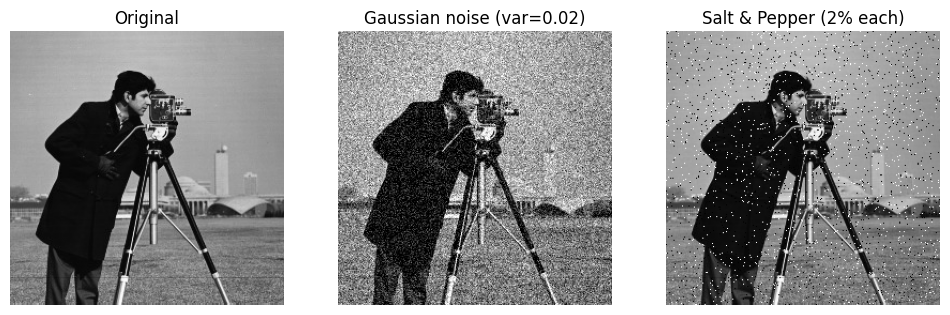

In [4]:
# Load image and show noisy versions
img = load_gray_image("cameraman.jpeg")
np.random.seed(0)

img_gauss = add_gaussian_noise(img, var=0.02)
img_sp = add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_gauss, cmap='gray'); plt.title('Gaussian noise (var=0.02)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_sp, cmap='gray'); plt.title('Salt & Pepper (2% each)'); plt.axis('off')
plt.show()

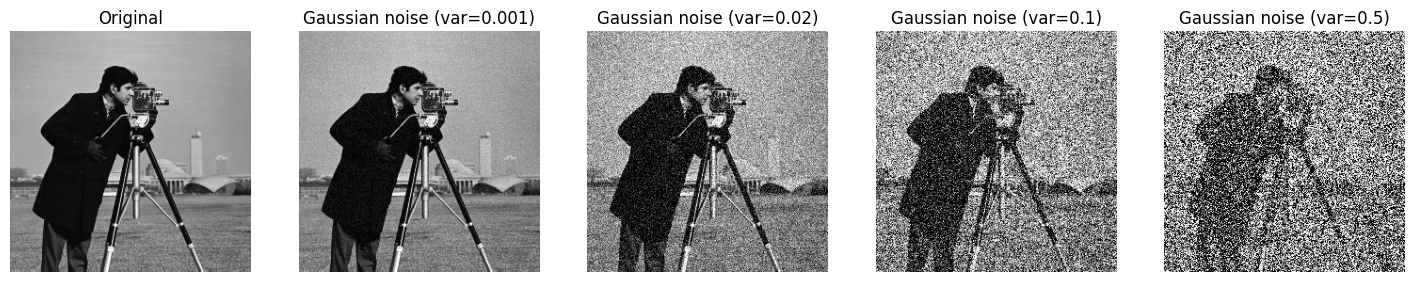

In [5]:
img_gauss_smallest = add_gaussian_noise(img, var=0.001)
img_gauss_small = add_gaussian_noise(img, var = 0.02)
img_gauss_med = add_gaussian_noise(img, var = 0.1)
img_gauss_large = add_gaussian_noise(img, var = 0.5)

plt.figure(figsize=(18, 12))
plt.subplot(1,5,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,5,2); plt.imshow(img_gauss_smallest, cmap='gray'); plt.title('Gaussian noise (var=0.001)'); plt.axis('off')
plt.subplot(1,5,3); plt.imshow(img_gauss_small, cmap='gray'); plt.title('Gaussian noise (var=0.02)'); plt.axis('off')
plt.subplot(1,5,4); plt.imshow(img_gauss_med, cmap='gray'); plt.title('Gaussian noise (var=0.1)'); plt.axis('off')
plt.subplot(1,5,5); plt.imshow(img_gauss_large, cmap='gray'); plt.title('Gaussian noise (var=0.5)'); plt.axis('off')
plt.show()

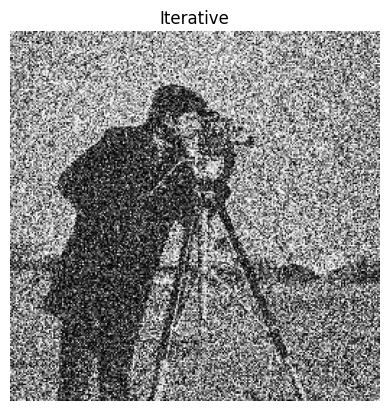

In [6]:
n = 100
img_gauss_n = np.copy(img)
for i in range(n):
    img_gauss_n = add_gaussian_noise(img_gauss_n, var = 0.001)
plt.imshow(img_gauss_n, cmap = 'gray'); plt.title('Iterative'); plt.axis('off')
plt.show()

## 2) Spatial-domain filters

**Box Filter**: Kernel has all values as the same

**Gaussian filter** (linear): convolution with a Gaussian kernel; good for smoothing Gaussian noise. Kernel equation:

$$
G(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}
$$

**Bilateral filter**: edge-preserving filter that weights both spatial distance and intensity difference.

### Bilateral Filter

The bilateral filter computes the output intensity at a pixel $p$ as:

$$
I_{out}(p) = \frac{1}{W_p} \sum_{q \in \Omega} I(q) \;
\exp\left(-\frac{\|p-q\|^2}{2\sigma_s^2}\right) \;
\exp\left(-\frac{(I(p)-I(q))^2}{2\sigma_r^2}\right)
$$

where:

- $I(p)$ : intensity at pixel $p$  
- $\Omega$ : neighborhood around $p$  
- $\sigma_s$ : spatial smoothing parameter (`sigmaSpace`)  
- $\sigma_r$ : range smoothing parameter (`sigmaColor`)  
- $W_p$ : normalization term, given by  

$$
W_p = \sum_{q \in \Omega}
\exp\left(-\frac{\|p-q\|^2}{2\sigma_s^2}\right) \;
\exp\left(-\frac{(I(p)-I(q))^2}{2\sigma_r^2}\right)
$$


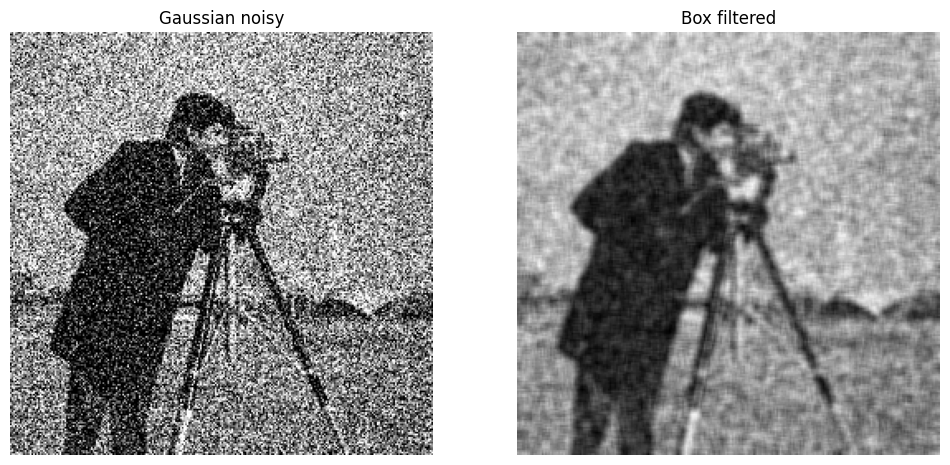

In [7]:
# Box Filter
N = 5
kern = np.ones((N, N)) / (N*N)
box_from_manual = convolve(img_gauss_med, kern, mode='reflect')

# Show
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_gauss_med, cmap='gray'); plt.title('Gaussian noisy'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(box_from_manual, cmap='gray'); plt.title('Box filtered'); plt.axis('off')
plt.show()

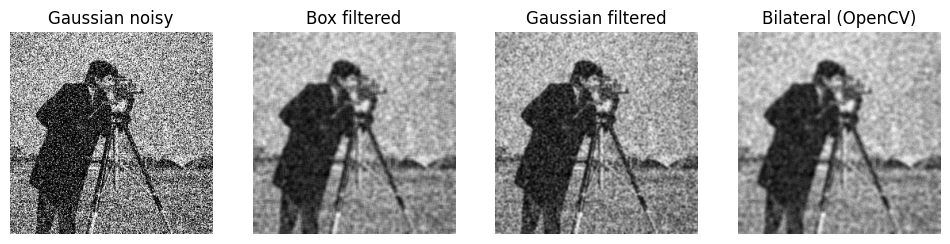

In [8]:
# Gaussian filter manual (convolution)
kern = gaussian_kernel(7, sigma=1)
gauss_from_manual = convolve(img_gauss_med, kern, mode='reflect')
# Bilateral filter (OpenCV) on u8
bilat = cv2.bilateralFilter(img_gauss_med, d=7, sigmaColor=75, sigmaSpace=75).astype(np.float32)/255.0

# Show
plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(img_gauss_med, cmap='gray'); plt.title('Gaussian noisy'); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(box_from_manual, cmap='gray'); plt.title('Box filtered'); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(gauss_from_manual, cmap='gray'); plt.title('Gaussian filtered'); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(bilat, cmap='gray'); plt.title('Bilateral (OpenCV)'); plt.axis('off')
plt.show()

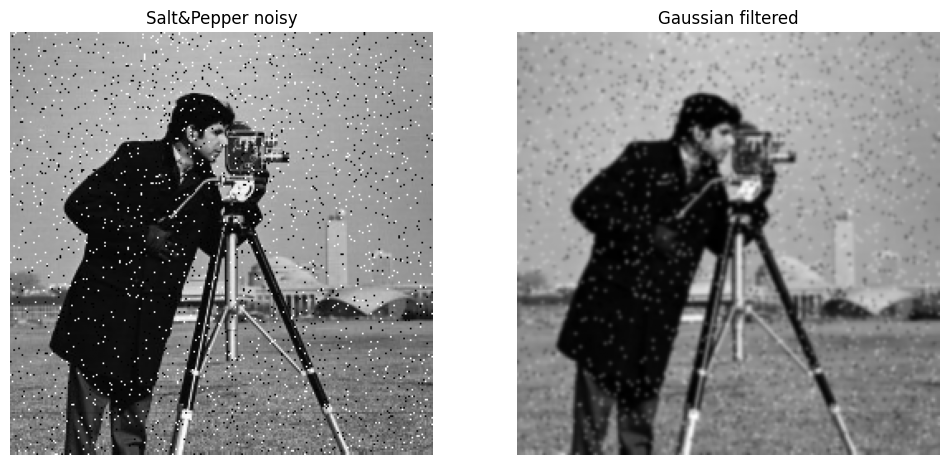

In [9]:
gauss_sp = convolve(img_sp, kern, mode='reflect')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_sp, cmap='gray'); plt.title('Salt&Pepper noisy'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(gauss_sp, cmap='gray'); plt.title('Gaussian filtered'); plt.axis('off')
plt.show()

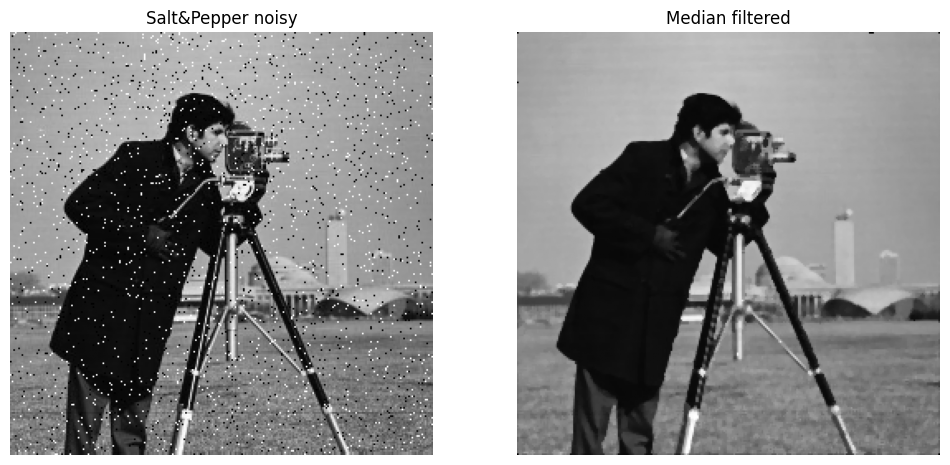

In [12]:
med_sp = medfilt2d(img_sp, kernel_size=3)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1);
plt.imshow(img_sp, cmap='gray'); plt.title('Salt&Pepper noisy'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(med_sp, cmap='gray'); plt.title('Median filtered'); plt.axis('off')
plt.show()

Manual Median Filter Time: 2.6940 s
SciPy medfilt2d Time: 0.0236 s
Max Pixel Difference: 0.615686297416687


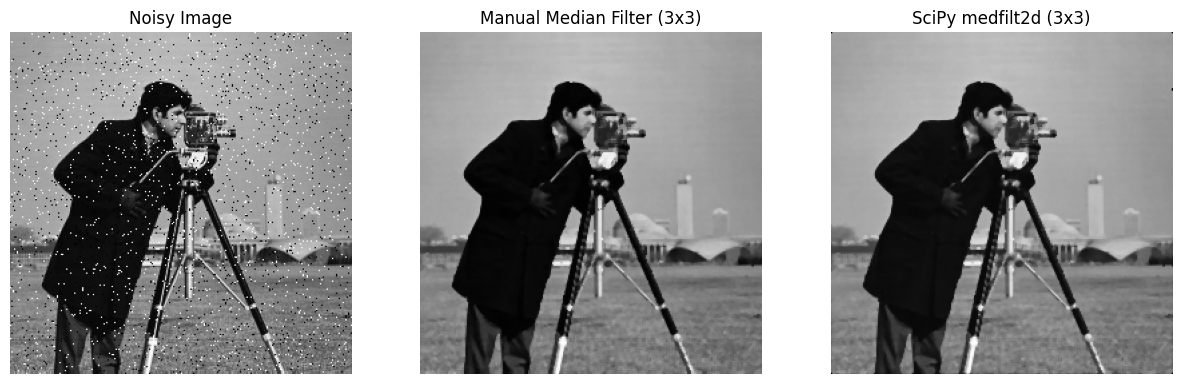

In [13]:
import time

noisy_img = add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02)
# -------------------- Manual Median Filter --------------------
def manual_median_filter(image, kernel_size=3):
  # write your code here
    pad = kernel_size // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)

    H, W = image.shape
    for i in range(H):
        for j in range(W):
            # window = np.sort(padded[i-kernel_size//2:i+kernel_size//2,j-kernel_size//2:j+kernel_size//2])
            window =padded[i:i+kernel_size,j:j+kernel_size]
            output[i, j] = np.median(window)
    return output

# -------------------- Compare Speed --------------------
ksize = 3

# Manual filter
t1 = time.time()
manual_filtered = manual_median_filter(noisy_img, kernel_size=ksize)
t2 = time.time()

# Built-in medfilt2d
t3 = time.time()
scipy_filtered = medfilt2d(noisy_img, kernel_size=ksize)
t4 = time.time()

print(f"Manual Median Filter Time: {(t2 - t1):.4f} s")
print(f"SciPy medfilt2d Time: {(t4 - t3):.4f} s")
print(f"Max Pixel Difference: {np.abs(manual_filtered - scipy_filtered).max()}")

# -------------------- Plot Results --------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(noisy_img, cmap='gray')
axs[0].set_title("Noisy Image")
axs[0].axis("off")

axs[1].imshow(manual_filtered, cmap='gray')
axs[1].set_title(f"Manual Median Filter ({ksize}x{ksize})")
axs[1].axis("off")

axs[2].imshow(scipy_filtered, cmap='gray')
axs[2].set_title(f"SciPy medfilt2d ({ksize}x{ksize})")
axs[2].axis("off")

plt.show()


## 3) Frequency-domain filtering (FFT)

Fourier transform (2D discrete):

$$
F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) e^{-j 2\pi (ux/M + vy/N)}
$$

We will build Gaussian low-pass and high-pass filters in the frequency domain. Steps:
1. Compute FFT of image
2. Shift zero-frequency to center (fftshift)
3. Multiply spectrum by filter mask
4. Inverse shift and inverse FFT



In [18]:
# Function to compute FFT and return fshift + magnitude spectrum
def compute_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return fshift, magnitude_spectrum

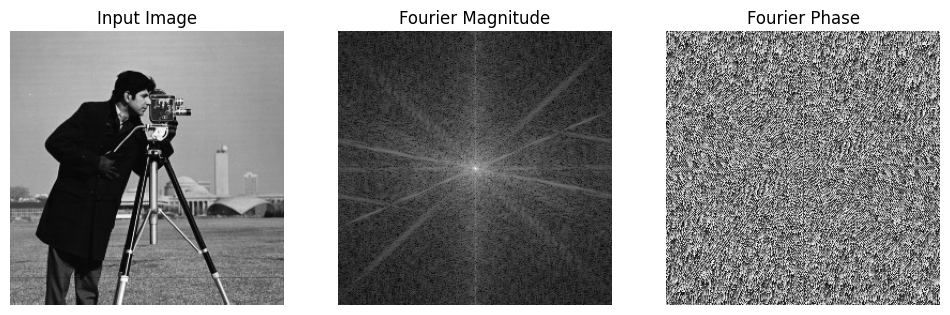

In [19]:
def plot_fourier(img):
    fshift_img, mag_img = compute_fft(img)
    phase = np.angle(fshift_img)
    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 1)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mag_img, cmap= "gray")
    plt.title("Fourier Magnitude")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(phase, cmap="gray")
    plt.title("Fourier Phase")
    plt.axis('off')


plot_fourier(img)

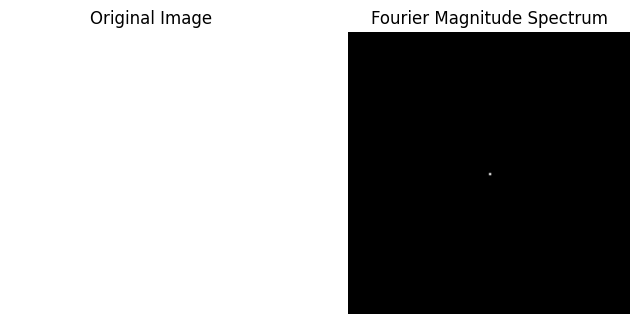

In [ ]:
def save_and_plot_fft(img, img_name="image", spectrum_name="spectrum"):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log1p(np.abs(fshift))  # log scaling

    plt.imsave(f"{img_name}.png", img, cmap="gray", vmin=0, vmax=1)

    plt.imsave(f"{spectrum_name}.png", magnitude_spectrum, cmap="gray")

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.title("Fourier Magnitude Spectrum")
    plt.axis("off")

    plt.show()

solid_image = np.ones(shape = (128, 128))
save_and_plot_fft(solid_image, "solid", "solid_spectrum")

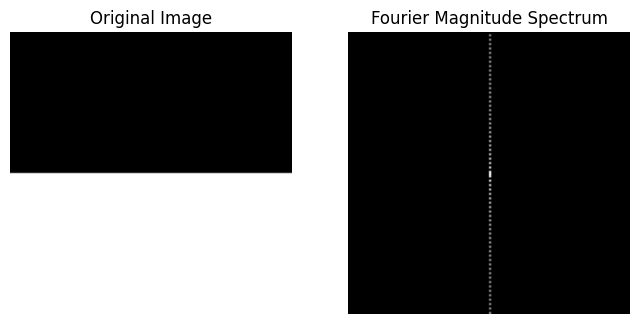

In [ ]:
def step_edge_x(height=128, width=128):
    img = np.zeros((height, width))
    img[:, width//2:] = 1   # right half white
    return img

def step_edge_y(height=128, width=128):
    img = np.zeros((height, width))
    img[height//2:, :] = 1  # bottom half white
    return img
img_x = step_edge_x()
img_y = step_edge_y()
save_and_plot_fft(img_y, "stepy", "stepy_spectrum")

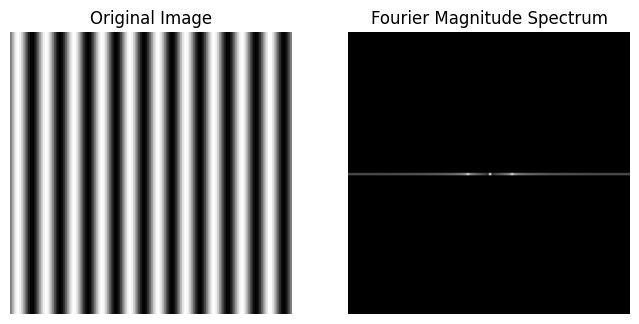

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sinusoidal_images(size=128, freq=5):
    x = np.linspace(0, 2*np.pi, size)
    y = np.linspace(0, 2*np.pi, size)
    xx, yy = np.meshgrid(x, y)

    # Sinusoid varying in x-direction (vertical stripes)
    x_sin = 0.5 * (1 + np.sin(freq * xx))  # normalize to [0,1]

    # Sinusoid varying in y-direction (horizontal stripes)
    y_sin = 0.5 * (1 + np.sin(freq * yy))  # normalize to [0,1]

    return x_sin, y_sin

# Example usage
xsin_img, ysin_img = sinusoidal_images(size=128, freq=10)
save_and_plot_fft(xsin_img, "sinx", "sinx_spectrum")

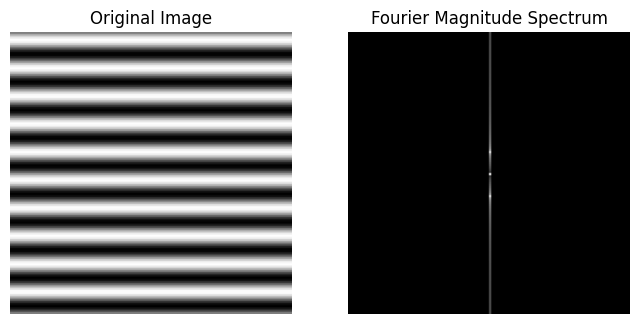

In [ ]:
save_and_plot_fft(ysin_img, "siny", "siny_spectrum")

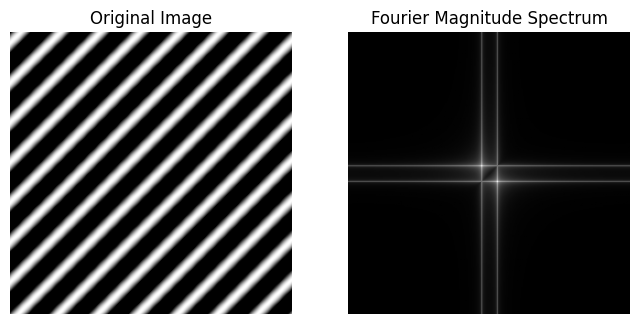

In [ ]:
def generate_45deg_sinusoid(size=256, frequency=10):
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    coord = (X + Y) / np.sqrt(2)

    sinusoid = np.sin(2 * np.pi * frequency * coord / size)

    return sinusoid

# Example usage
sin45_img = generate_45deg_sinusoid(size=256, frequency=10)
save_and_plot_fft(sin45_img, "sin45", "sin45_spectrum")


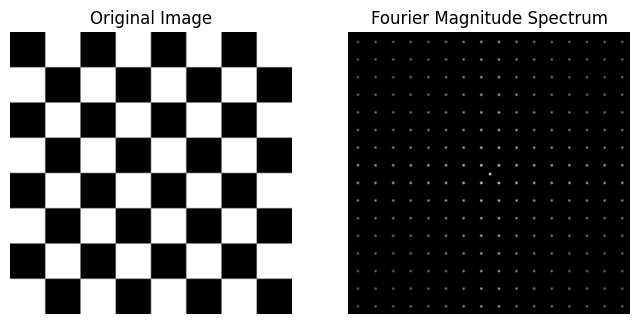

In [ ]:

def generate_chessboard(size=256, num_squares=8):
    # Pixel grid
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    # Size of each square
    square_size = size // num_squares

    # Alternating pattern using integer division
    board = ((X // square_size) + (Y // square_size)) % 2

    return board

# Example usage
chessboard_img = generate_chessboard(size=128, num_squares=8)
save_and_plot_fft(chessboard_img, "chessboard", "chessboard_spectrum")

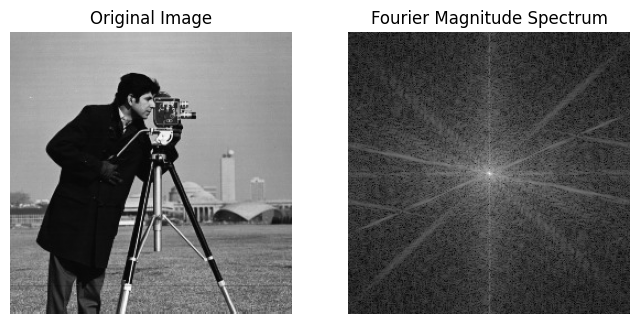

In [ ]:
save_and_plot_fft(img, "cameraman", "cameraman_spectrum")

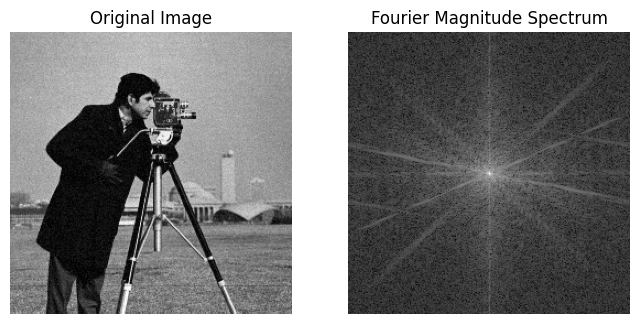

In [ ]:
save_and_plot_fft(img_gauss_smallest, "camgauss", "camgauss_spectrum")

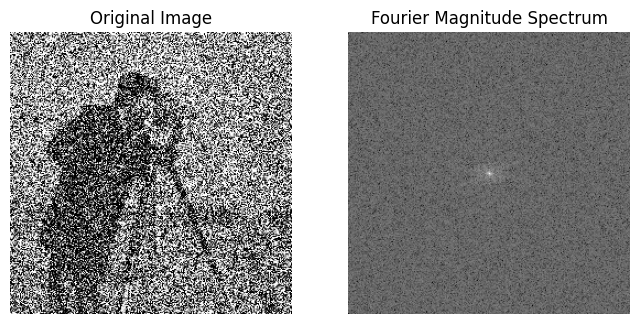

In [ ]:
save_and_plot_fft(img_gauss_large, "camgauss", "camgauss_spectrum")

In [ ]:
pad_kern = np.zeros_like(img, dtype=np.float32)
kern = gaussian_kernel(5, sigma=1)
kh, kw = kern.shape
r, c = img.shape

# # Compute starting indices for centering
start_x = (r - kh) // 2
start_y = (c - kw) // 2
plt.imsave("gauss_small.png", kern, cmap="gray")
pad_kern[start_x:start_x+kh, start_y:start_y+kw] = kern
# save_and_plot_fft(pad_kern, "gauss", "gauss_spectrum")

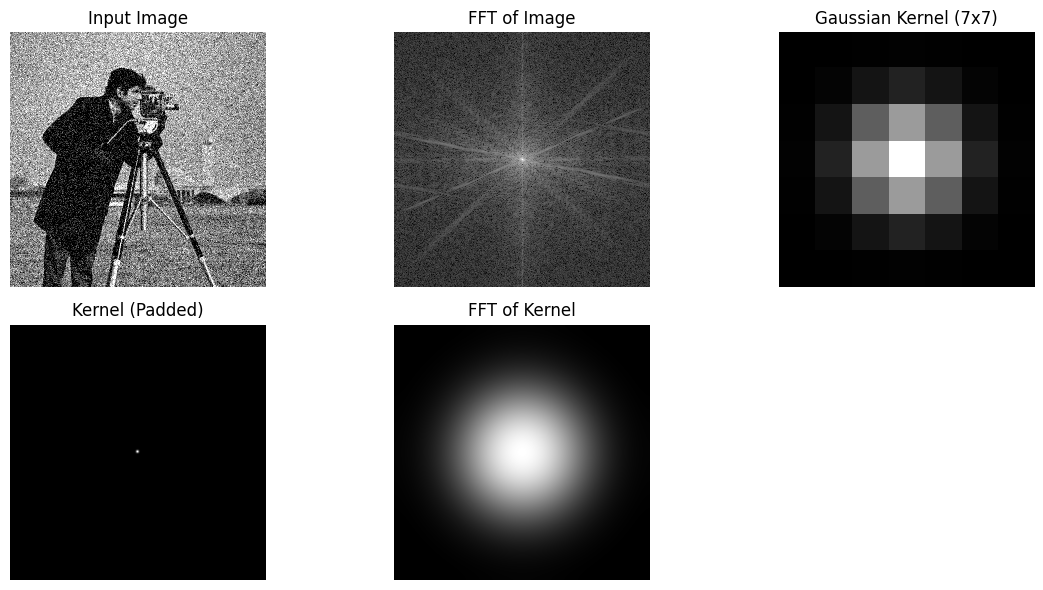

In [ ]:
kern = gaussian_kernel(7, sigma=1)
# Pad kernel to match image size, centered
pad_kern = np.zeros_like(img, dtype=np.float32)
kh, kw = kern.shape
r, c = img.shape

# # Compute starting indices for centering
start_x = (r - kh) // 2
start_y = (c - kw) // 2

pad_kern[start_x:start_x+kh, start_y:start_y+kw] = kern


# Compute FFTs
fshift_img, mag_img = compute_fft(img_gauss_smallest)
fshift_kern, mag_kern = compute_fft(pad_kern)

# Plot results1
plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.imshow(img_gauss, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mag_img, cmap='gray')
plt.title("FFT of Image")
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(kern, cmap='gray')
plt.title("Gaussian Kernel (7x7)")
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(pad_kern, cmap='gray')
plt.title("Kernel (Padded)")
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(mag_kern, cmap='gray')
plt.title("FFT of Kernel")
plt.axis('off')

plt.tight_layout()
plt.show()

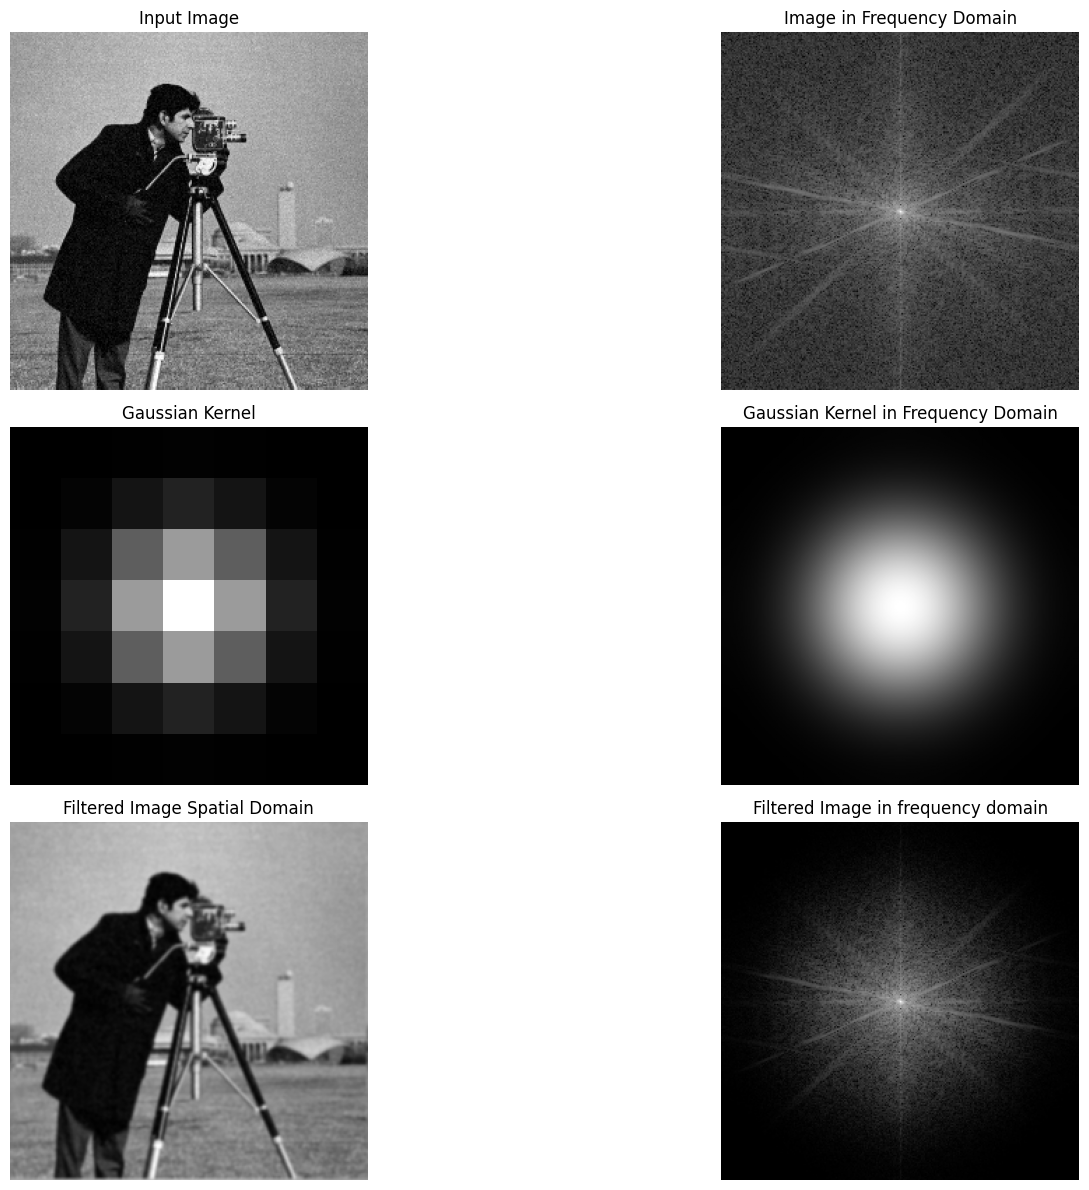

In [ ]:
# Filtering in frequency domain
filtered_fft = fshift_img * fshift_kern
filtered_fft_mag = np.log(np.abs(filtered_fft) + 1)
filtered_img = np.fft.ifft2(np.fft.ifftshift(filtered_fft))
filtered_img = np.abs(fftshift(filtered_img))

# Show results
plt.figure(figsize=(18,12))
plt.subplot(3,2,1)
plt.imshow(img_gauss_smallest, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(mag_img, cmap='gray')
plt.title("Image in Frequency Domain")
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow(kern, cmap='gray')
plt.title("Gaussian Kernel")
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow(mag_kern, cmap='gray')
plt.title("Gaussian Kernel in Frequency Domain")
plt.axis('off')


plt.subplot(3,2,5)
plt.imshow(filtered_img, cmap='gray')
plt.title("Filtered Image Spatial Domain")
plt.axis('off')

plt.subplot(3,2,6)
plt.imshow(filtered_fft_mag, cmap='gray')
plt.title("Filtered Image in frequency domain")
plt.axis('off')
plt.tight_layout()
plt.show()

plt.imsave("filtered_fft_mag.png", filtered_fft_mag, cmap="gray")
plt.imsave("filtered_img.png", filtered_img, cmap="gray")

## 4) Discussion & comparisons

- Median filtering is non-linear and cannot be represented simply as multiplication in the frequency domain.
- Bilateral filter is non-linear and edge-preserving; it does not have a simple frequency-domain equivalent.

Try the exercises in the next cell to explore differences quantitatively.

### Exercises (Try-it-yourself)

1. Vary Gaussian noise variance (try 0.005, 0.01, 0.02, 0.05)
2. Change Gaussian kernel sigma in spatial domain and sigma in FFT mask to match — compare results.
3. Implement a frequency-domain high-pass filter (H_hp = 1 - H_lp) and observe edge enhancement and compare with bilateral filter
4. Implement median filter manually (sliding window) and compare speed/quality with `medfilt2d`.



### Compute histogram

(375, 500)
Max pixel difference between manual and OpenCV: 1


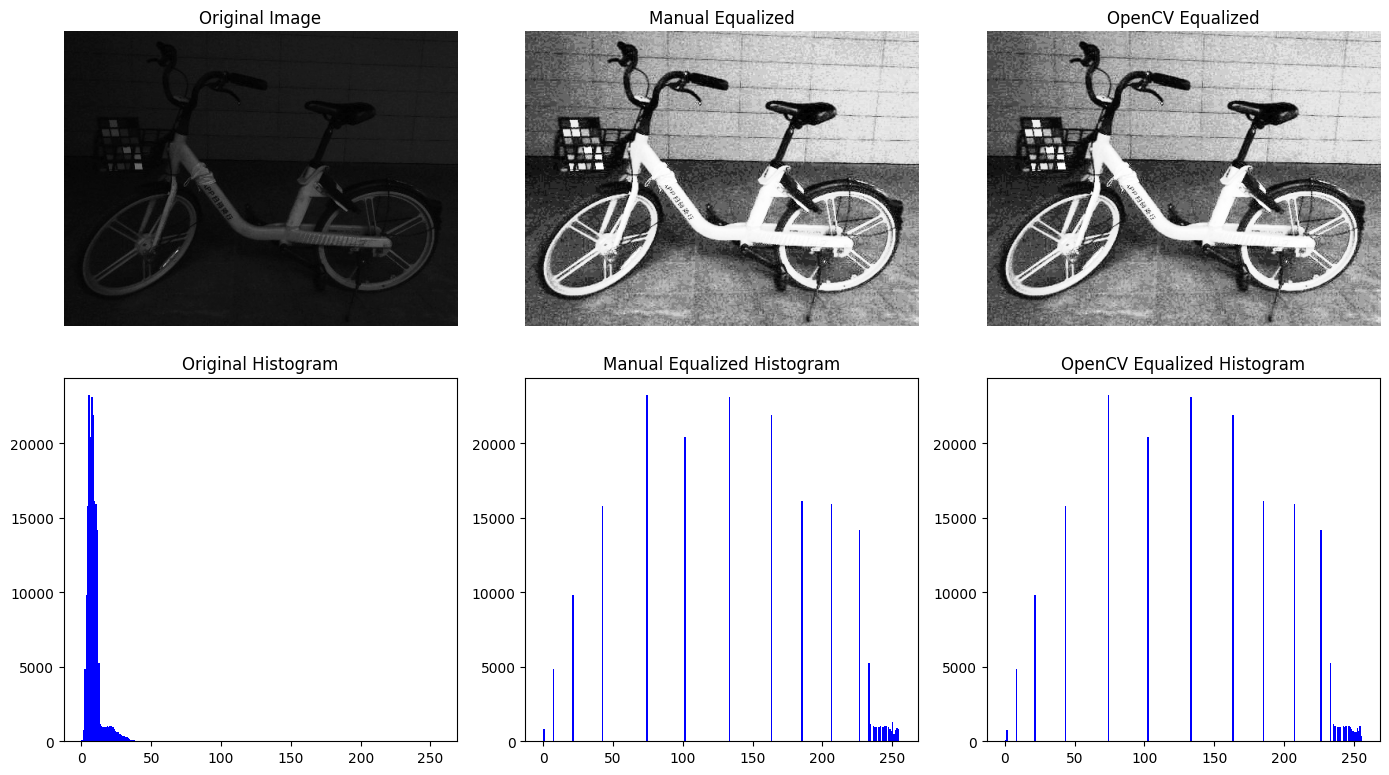

In [ ]:
# img = load_gray_image("haze.png")
img = load_gray_image("ll.JPG")

def hist_eq(img):
  # If img is already normalized float32 [0,1], convert it back to uint8 [0,255]
  if img.dtype == np.float32 or img.dtype == np.float64:
      if img.max() <= 1.0:   # assume normalized
          img_uint8 = (img * 255).astype(np.uint8)
      else:
          img_uint8 = img.astype(np.uint8)
  else:
      img_uint8 = img

  # -------- Manual Histogram Equalization --------
  # Step 1: Histogram
  hist, bins = np.histogram(img_uint8.flatten(), 256, [0,256])

  # Step 2: CDF
  cdf = hist.cumsum()

  # Step 3: Normalize CDF
  cdf_min = cdf[cdf > 0].min()
  cdf_max = cdf.max()
  cdf_scaled = (cdf - cdf_min) * 255 / (cdf_max - cdf_min)
  cdf_scaled = cdf_scaled.astype(np.uint8)

  # Step 4: Apply mapping
  manual_eq = cdf_scaled[img_uint8]

  # -------- OpenCV Histogram Equalization --------
  opencv_eq = cv2.equalizeHist(img_uint8)

  # -------- Difference Check --------
  diff = np.abs(manual_eq.astype(int) - opencv_eq.astype(int))
  print("Max pixel difference between manual and OpenCV:", diff.max())

  return img_uint8, manual_eq, opencv_eq

img_uint8, manual_eq, opencv_eq = hist_eq(img)

# -------- Plot Results --------
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.title("Original Image")
plt.imshow(img_uint8, cmap="gray")
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Manual Equalized")
plt.imshow(manual_eq, cmap="gray")
plt.axis("off")

plt.subplot(2,3,3)
plt.title("OpenCV Equalized")
plt.imshow(opencv_eq, cmap="gray")
plt.axis("off")

plt.subplot(2,3,4)
plt.title("Original Histogram")
plt.hist(img_uint8.flatten(), 256, range=[0,256], color='blue')


plt.subplot(2,3,5)
plt.title("Manual Equalized Histogram")
plt.hist(manual_eq.flatten(), 256, range=[0,256], color='blue')


plt.subplot(2,3,6)
plt.title("OpenCV Equalized Histogram")
plt.hist(opencv_eq.flatten(), 256, range=[0,256], color='blue')


plt.tight_layout()
plt.show()


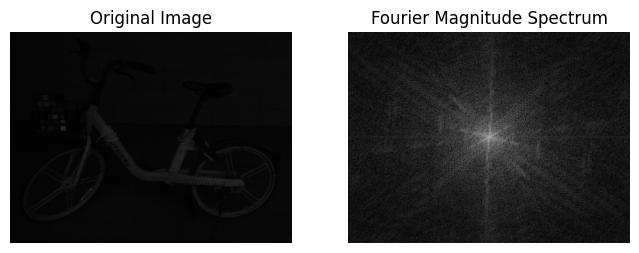

In [ ]:

save_and_plot_fft(img, "low_light", "low_light_spectrum")

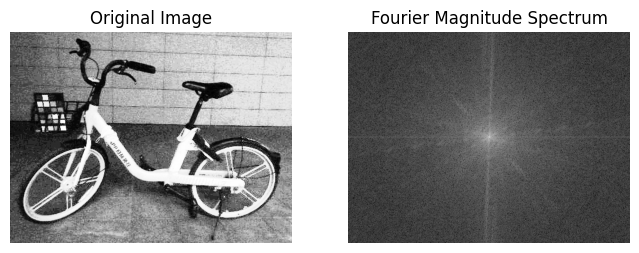

In [ ]:
equalized_img = opencv_eq.astype(np.float32) / 255.0
save_and_plot_fft(equalized_img, "low_light_eq", "low_light_eq_spec")

### Try histogram equalization with hazy image, read image as rgb image and apply histogram equalizatiom